In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

2024-03-18 18:32:54.127395: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
base_dir = 'Dataset_Structures_modes/ImageDataGen_825_cleaned'
train_raw_path = os.path.join(base_dir,'train' )
validation_raw_path = os.path.join(base_dir,'val' )
test_raw_path = os.path.join(base_dir,'test' )

In [3]:
def preprocess_image_grayscale(img):
    """Convertit une image RGB en niveaux de gris et la duplique sur 3 canaux."""
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img)
    return img

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image_grayscale )
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image_grayscale )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image_grayscale )

In [6]:
batch_size = 32

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_raw_path,
        target_size=(256, 256),
        color_mode='rgb',  # Même si c'est en niveaux de gris, on charge comme RGB
        batch_size=batch_size,
        class_mode='binary')

Found 740 images belonging to 2 classes.


In [8]:
validation_generator = validation_datagen.flow_from_directory(
        validation_raw_path,
        target_size=(256, 256),
        color_mode='rgb',  # Même si c'est en niveaux de gris, on charge comme RGB
        batch_size=batch_size,
        class_mode='binary')

Found 182 images belonging to 2 classes.


In [9]:
test_generator = validation_datagen.flow_from_directory(
        test_raw_path,
        target_size=(256, 256),
        color_mode='rgb',  # Même si c'est en niveaux de gris, on charge comme RGB
        batch_size=batch_size,
        class_mode='binary')

Found 52 images belonging to 2 classes.


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [11]:
input_shape = (256, 256, 3)  # Assurez-vous que cette taille est compatible avec MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Geler les poids du modèle pré-entraîné pour ne pas les modifier lors du premier cycle d'entraînement
base_model.trainable = False


2024-03-18 18:32:56.638965: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-03-18 18:32:56.674515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 18:32:56.674662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2024-03-18 18:32:56.674689: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-03-18 18:32:56.685642: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-03-18 18:32:56.685775: I tensorflow/stream_executo

In [12]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [13]:
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/home/riccardo/anaconda3/envs/py39_tf250/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)

Training

In [15]:
history = model.fit(
    train_generator,  # Ajustez en fonction de la taille de votre ensemble d'entraînement
    epochs=40,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr])

2024-03-18 18:32:58.865214: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2024-03-18 18:32:59.112336: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-03-18 18:33:01.084289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-03-18 18:33:01.102857: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3399905000 Hz


Epoch 1/40


2024-03-18 18:33:04.878948: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-03-18 18:33:04.884283: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8906


24/24 [==============================] - 81s 3s/step - loss: 0.7186 - accuracy: 0.6122 - val_loss: 0.8427 - val_accuracy: 0.4505
Epoch 2/40
24/24 [==============================] - 75s 3s/step - loss: 0.5442 - accuracy: 0.7243 - val_loss: 0.7379 - val_accuracy: 0.5385
Epoch 3/40
24/24 [==============================] - 72s 3s/step - loss: 0.4908 - accuracy: 0.7527 - val_loss: 0.6056 - val_accuracy: 0.6593
Epoch 4/40
24/24 [==============================] - 72s 3s/step - loss: 0.4679 - accuracy: 0.7662 - val_loss: 0.5666 - val_accuracy: 0.7253
Epoch 5/40
24/24 [==============================] - 73s 3s/step - loss: 0.4138 - accuracy: 0.7986 - val_loss: 0.4727 - val_accuracy: 0.7912
Epoch 6/40
24/24 [==============================] - 74s 3s/step - loss: 0.4150 - accuracy: 0.8203 - val_loss: 0.4093 - val_accuracy: 0.8462
Epoch 7/40
24/24 [==============================] - 71s 3s/step - loss: 0.3537 - accuracy: 0.8446 - val_loss: 0.3871 - val_accuracy: 0.8516
Epoch 8/40
24/24 [=============

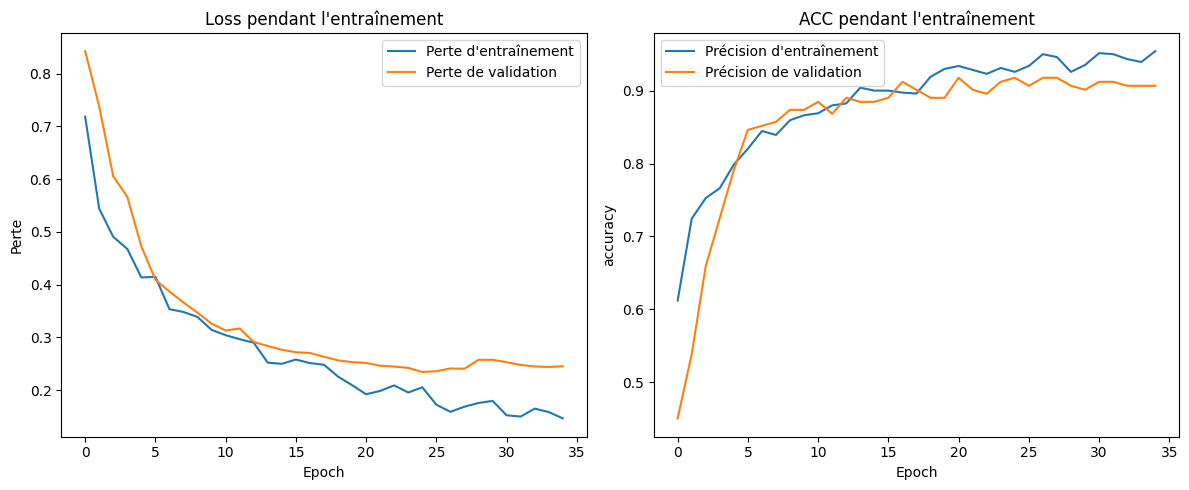

In [16]:
    # Afficher les courbes d'entraînement
plt.figure(figsize=(12, 5))

# Affichage de la perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Loss pendant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()

# Affichage de la précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history.history['val_accuracy'], label='Précision de validation')
plt.title('ACC pendant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Saving model and training score 

In [17]:
model.save('Class_pearl_mart_cleaned_V8_batch32_grey_865_without_lowconfV2.h5')  # Sauvegarde le modèle au format HDF5

/home/riccardo/anaconda3/envs/py39_tf250/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [18]:
import pickle
with open('Class_pearl_mart_cleaned_V8_batch32_grey_histo_865_without_lowconf_V2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [4]:
import pickle
with open('/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/Models/Main_classification_model/Class_pearl_mart_cleaned_V4_batch16_grey_histo.pkl', 'rb') as f:
    historique_charge = pickle.load(f)

Predicting 

In [40]:
def prepare_img(img_path, target_size=(256, 256)):
    from tensorflow.keras.preprocessing import image
    import numpy as np
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [41]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_class_with_confidence(model, img_path, threshold=0.5):
    """
    Prédit si une image est de la classe 'Perlites' ou 'Martensites' en utilisant un modèle donné,
    et fournit le pourcentage de confiance de cette prédiction.
    
    Args:
    - model: Le modèle entraîné pour la prédiction.
    - img_path (str): Le chemin vers l'image à prédire.
    - threshold (float): Le seuil pour décider de la classe.
    
    Returns:
    - tuple: La prédiction de la classe ('Perlites' ou 'Martensites') et le pourcentage de confiance.
    """
    # Chargement et prétraitement de l'image
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convertit l'image en un batch de taille 1
        
    # Faire la prédiction
    prediction = model.predict(img_array)
    confidence = prediction[0][0]  # Obtient la confiance de la prédiction
    
    # Interpréter la prédiction
    predicted_class = 'Perlites' if confidence >= threshold else 'Martensites'
    confidence_percentage = confidence * 100 if predicted_class == 'Perlites' else (1 - confidence) * 100
    
    return predicted_class, confidence_percentage

In [42]:
# Exemple d'utilisation
img_path = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/Dataset_Structures_modes/ImageDataGen_1300img/train/Pearlite/2-Figure1-1 (3)_cropped_1.png'
predicted_class, confidence = predict_class_with_confidence(model, img_path, threshold=0.5)
print(f"Classe prédite : {predicted_class} avec {confidence:.2f}% de confiance")

Classe prédite : Perlites avec 88.85% de confiance
